# Homework 3

## FINM 35700 - Spring 2023

### UChicago Financial Mathematics

* Aman Krishna
* aman.krishna@uchicago.edu

This homework relies on:

- the US government bonds symbology file `govt_symbology`, 
- the "on-the-run" treasuries data file `govt_on_the_run`,
- the corporate  bonds symbology file `corp_symbology`,
- the market data file `market_prices_eod` and
- the corporate bonds call schedule file `call_schedules`.


# Problem 1: More details on callable bonds: "workout-date" and "yield-to-worst" calculations

In [420]:
import QuantLib as ql
import numpy as np
import pandas as pd
import datetime as dt
import os
import matplotlib.pyplot as plt
import random
from datetime import datetime
from scipy.optimize import fsolve

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Use static calculation/valuation date of 2023-04-14, matching data available in the market prices EOD file
calc_date = ql.Date(14, 4, 2023)
ql.Settings.instance().evaluationDate = calc_date

mydir = os.getcwd()

In [421]:
# Calculate initial term and current time-to-maturity for each bond issue
def get_symbology(df, underlying=False):
    for index, row in df.iterrows():
        start_date = ql.Date(row['start_date'].day, row['start_date'].month, row['start_date'].year)
        maturity_date = ql.Date(row['maturity'].day, row['maturity'].month, row['maturity'].year)
        today_date = ql.Date(14,4,2023)
        calendar = ql.UnitedStates(ql.UnitedStates.GovernmentBond)
        #set dcc as Actual/365.25
        dcc = ql.Actual36525()
        initial_term = dcc.yearFraction(start_date, maturity_date)
        current_time_to_maturity = dcc.yearFraction(today_date, maturity_date)
        df.at[index, 'term'] = initial_term
        df.at[index, 'TTM'] = current_time_to_maturity

    if underlying:
        return df[['ticker','figi','security','name','und_bench_isin','coupon','days_settle','start_date','acc_first', 'maturity', 'term', 'TTM']]
    else:
        #round term to integer
        df['term'] = round(df['term'],2)
        df1 = df[['ticker','figi','security','name','coupon','days_settle','start_date','acc_first', 'maturity', 'term', 'TTM']]
        return df1

In [422]:
def get_ql_date(date) -> ql.Date:
    """
    convert dt.date to ql.Date
    """
    if isinstance(date, dt.date):
        return ql.Date(date.day, date.month, date.year)
    elif isinstance(date, str):
        date = dt.datetime.strptime(date, "%Y-%m-%d").date()
        return ql.Date(date.day, date.month, date.year)
    else:
        raise ValueError(f"to_qldate, {type(date)}, {date}")

In [423]:
def create_schedule_from_symbology(details: dict):
    '''Create a QuantLib cashflow schedule from symbology details dictionary (usually one row of the symbology dataframe)
    '''
    # Create maturity from details['maturity']
    maturity = ql.Date(details['maturity'].day, details['maturity'].month, details['maturity'].year)
    
    # Create acc_first from details['acc_first']
    acc_first = ql.Date(details['acc_first'].day, details['acc_first'].month, details['acc_first'].year)
    
    # Create calendar for Corp and Govt asset classes
    calendar = ql.UnitedStates(ql.UnitedStates.GovernmentBond)
    
    # define period from details['cpn_freq'] ... can be hard-coded to 2 = semi-annual frequency
    period = ql.Period(ql.Semiannual)
    
    # business_day_convention
    business_day_convention = ql.Unadjusted
    
    # termination_date_convention
    termination_date_convention = ql.Unadjusted
    
    # date_generation
    date_generation=ql.DateGeneration.Backward
    
    # Create schedule using ql.MakeSchedule interface (with keyword arguments)
    schedule = ql.MakeSchedule(effectiveDate=acc_first,  # this may not be the same as the bond's start date
                            terminationDate=maturity,
                            tenor=period,
                            calendar=calendar,
                            convention=business_day_convention,
                            terminalDateConvention=termination_date_convention,
                            rule=date_generation,
                            endOfMonth=True,
                            firstDate=ql.Date(),
                            nextToLastDate=ql.Date())
    return schedule

In [424]:
def create_bond_from_symbology(details: dict):
    '''Create a US fixed rate bond object from symbology details dictionary (usually one row of the symbology dataframe)
    '''
    
     # Create day_count from details['dcc']
     # For US Treasuries use ql.ActualActual(ql.ActualActual.ISMA)
     # For US Corporates use ql.Thirty360(ql.Thirty360.USA)
     
    if details['ticker'] == 'T':
        day_count = ql.ActualActual(ql.ActualActual.ISMA)
    else:
        day_count = ql.Thirty360(ql.Thirty360.USA)
    
    # Create day_count from details['start_date']    
    issue_date = ql.Date(details['start_date'].day, details['start_date'].month, details['start_date'].year)
    
    # Create days_settle from details['days_settle']
    days_settle = int(float(details['days_settle']))

    # Create days_settle from details['coupon']
    coupon = float(details['coupon'])/100.

    # Create cashflow schedule
    schedule = create_schedule_from_symbology(details)
    
    face_value = 100
    redemption = 100
    
    payment_convention = ql.Unadjusted
        
    # Create fixed rate bond object
    fixed_rate_bond = ql.FixedRateBond(
        days_settle,
        face_value,
        schedule,
        [coupon],
        day_count,
        payment_convention,
        redemption,
        issue_date)        

    return fixed_rate_bond


## a. Load and explore the call schedules dataframe

Load the `call_schedules` Excel file into a dataframe. It contains call schedules for fixed-rate, callable corporate bonds.

For each bond in the dataframe, compute the total number of outstanding calls.

In [425]:
call_schedules = pd.read_excel(os.path.join(mydir, 'data', 'call_schedules.xlsx'))

In [426]:
call_schedules

,isin,figi,call_date,call_price
0,US254687CZ75,BBG00QNKJ092,2024-06-15,100
1,US254687DD54,BBG00QNKPCL5,2025-07-15,100
2,US254687DK97,BBG00QNKGJP6,2026-08-15,100
3,US254687EX00,BBG00QNKKP22,2045-04-15,100
4,US254687FB70,BBG00QNKKP68,2046-05-15,100
...,...,...,...,...
110,US92346MHV63,BBG012F6PR25,2031-03-15,100
111,US92346MJS17,BBG0175X1628,2023-05-15,100
112,US92346MJZ59,BBG017QYK9Z0,2023-06-15,100
113,US92346MKG59,BBG0191HMXJ3,2023-08-15,100


In [427]:
#group by isin and count number of call_date
call_schedules['num_call_dates'] = call_schedules.groupby('isin')['call_date'].transform('count')
call_schedules

,isin,figi,call_date,call_price,num_call_dates
0,US254687CZ75,BBG00QNKJ092,2024-06-15,100,1
1,US254687DD54,BBG00QNKPCL5,2025-07-15,100,1
2,US254687DK97,BBG00QNKGJP6,2026-08-15,100,1
3,US254687EX00,BBG00QNKKP22,2045-04-15,100,1
4,US254687FB70,BBG00QNKKP68,2046-05-15,100,1
...,...,...,...,...,...
110,US92346MHV63,BBG012F6PR25,2031-03-15,100,16
111,US92346MJS17,BBG0175X1628,2023-05-15,100,1
112,US92346MJZ59,BBG017QYK9Z0,2023-06-15,100,1
113,US92346MKG59,BBG0191HMXJ3,2023-08-15,100,1


## b. Load symbology dataframe and extend it with the fixed-rate callable corporate bond details from 1a.

Load the `corp_symbology` Excel file into a dataframe and keep only the fixed-rate callable bonds from 1a.

Extend the dataframe with the column computed in 1a:

| num_call_dates |
|----------|

In [428]:
corp_symbology = pd.read_excel(os.path.join(mydir, 'data', 'corp_symbology.xlsx'))
corp_symbology

,ticker,class,figi,isin,trace,und_bench_isin,security,name,type,coupon,...,cpn_freq,days_settle,start_date,cpn_first,acc_first,maturity,mty_typ,rank,country,currency
0,DIS,Corp,BBG00QNKJ092,US254687CZ75,DIS4921182,US91282CGU99,DIS 3.7 09/15/24,WALT DISNEY COMPANY/THE,GLOBAL,3.700,...,2,2,2019-11-22,2020-03-15,2019-09-15,2024-09-15,CALLABLE,Sr Unsecured,US,USD
1,DIS,Corp,BBG00QNKPCL5,US254687DD54,DIS4907444,US91282CGU99,DIS 3.7 10/15/25,WALT DISNEY COMPANY/THE,GLOBAL,3.700,...,2,2,2019-11-22,2020-04-15,2019-10-15,2025-10-15,CALLABLE,Sr Unsecured,US,USD
2,DIS,Corp,BBG00QNKGJP6,US254687DK97,DIS4907439,US91282CGR60,DIS 3 3/8 11/15/26,WALT DISNEY COMPANY/THE,GLOBAL,3.375,...,2,2,2019-11-22,2020-05-15,2019-11-15,2026-11-15,CALLABLE,Sr Unsecured,US,USD
3,DIS,Corp,BBG00QNKP8R8,US254687DV52,DIS4908605,US91282CGM73,DIS 6.55 03/15/33,WALT DISNEY COMPANY/THE,GLOBAL,6.550,...,2,2,2019-11-22,2020-03-15,2019-09-15,2033-03-15,AT MATURITY,Sr Unsecured,US,USD
4,DIS,Corp,BBG00QNKR4J4,US254687DZ66,DIS4908062,US91282CGM73,DIS 6.2 12/15/34,WALT DISNEY COMPANY/THE,GLOBAL,6.200,...,2,2,2019-11-22,2019-12-15,2019-06-15,2034-12-15,AT MATURITY,Sr Unsecured,US,USD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260,VZ,Corp,BBG017BR3G75,US92346MJT99,VZ5414106,US91282CGT27,VZ 4.15 05/15/29,VERIZON COMMUNICATIONS,DOMESTIC MTN,4.150,...,2,2,2022-05-19,2022-11-15,2022-05-19,2029-05-15,CALLABLE,Sr Unsecured,US,USD
261,VZ,Corp,BBG017QYK9Z0,US92346MJZ59,VZ5420578,US912810TL26,VZ 4.65 06/15/52,VERIZON COMMUNICATIONS,DOMESTIC MTN,4.650,...,2,2,2022-06-03,2022-12-15,2022-06-03,2052-06-15,CALLABLE,Sr Unsecured,US,USD
262,VZ,Corp,BBG0191HMXJ3,US92346MKG59,VZ5458130,US912810TL26,VZ 4.6 08/15/52,VERIZON COMMUNICATIONS,DOMESTIC MTN,4.600,...,2,2,2022-08-11,2023-02-15,2022-08-11,2052-08-15,CALLABLE,Sr Unsecured,US,USD
263,VZ,Corp,BBG019LXC9P3,US92346MKQ32,VZ5477070,US91282CGT27,VZ 4 1/2 09/15/29,VERIZON COMMUNICATIONS,DOMESTIC MTN,4.500,...,2,2,2022-09-22,2023-03-15,2022-09-22,2029-09-15,CALLABLE,Sr Unsecured,US,USD


In [429]:
corp_symbology_call = corp_symbology[corp_symbology['cpn_type'] == 'FIXED']
corp_symbology_call = corp_symbology_call.reset_index(drop=True)

#merge corp_symbology with call_schedules and keep only bonds in call_schedules
corp_symbology_call = corp_symbology_call.merge(call_schedules, how='inner', on='isin')

#rename figi_x to figi and drop figi_y
corp_symbology_call = corp_symbology_call.rename(columns={'figi_x':'figi'})
corp_symbology_call = corp_symbology_call.drop(columns=['figi_y'])

In [430]:
corp_symbology_call

,ticker,class,figi,isin,trace,und_bench_isin,security,name,type,coupon,...,cpn_first,acc_first,maturity,mty_typ,rank,country,currency,call_date,call_price,num_call_dates
0,DIS,Corp,BBG00QNKJ092,US254687CZ75,DIS4921182,US91282CGU99,DIS 3.7 09/15/24,WALT DISNEY COMPANY/THE,GLOBAL,3.700,...,2020-03-15,2019-09-15,2024-09-15,CALLABLE,Sr Unsecured,US,USD,2024-06-15,100,1
1,DIS,Corp,BBG00QNKPCL5,US254687DD54,DIS4907444,US91282CGU99,DIS 3.7 10/15/25,WALT DISNEY COMPANY/THE,GLOBAL,3.700,...,2020-04-15,2019-10-15,2025-10-15,CALLABLE,Sr Unsecured,US,USD,2025-07-15,100,1
2,DIS,Corp,BBG00QNKGJP6,US254687DK97,DIS4907439,US91282CGR60,DIS 3 3/8 11/15/26,WALT DISNEY COMPANY/THE,GLOBAL,3.375,...,2020-05-15,2019-11-15,2026-11-15,CALLABLE,Sr Unsecured,US,USD,2026-08-15,100,1
3,DIS,Corp,BBG00QNKKP22,US254687EX00,DIS4920157,US912810TQ13,DIS 4.95 10/15/45,WALT DISNEY COMPANY/THE,GLOBAL,4.950,...,2020-04-15,2019-10-15,2045-10-15,CALLABLE,Sr Unsecured,US,USD,2045-04-15,100,1
4,DIS,Corp,BBG00QNKKP68,US254687FB70,DIS4907442,US912810TQ13,DIS 4 3/4 11/15/46,WALT DISNEY COMPANY/THE,GLOBAL,4.750,...,2020-05-15,2019-11-15,2046-11-15,CALLABLE,Sr Unsecured,US,USD,2046-05-15,100,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,VZ,Corp,BBG012F6PR25,US92346MHV63,VZ5256196,US912810TL26,VZ 3.05 09/15/51,VERIZON COMMUNICATIONS,DOMESTIC MTN,3.050,...,2022-03-15,2021-09-16,2051-09-15,CALLABLE,Sr Unsecured,US,USD,2031-03-15,100,16
111,VZ,Corp,BBG0175X1628,US92346MJS17,VZ5410330,US912810TL26,VZ 4.55 05/15/52,VERIZON COMMUNICATIONS,DOMESTIC MTN,4.550,...,2022-11-15,2022-05-12,2052-05-15,CALLABLE,Sr Unsecured,US,USD,2023-05-15,100,1
112,VZ,Corp,BBG017QYK9Z0,US92346MJZ59,VZ5420578,US912810TL26,VZ 4.65 06/15/52,VERIZON COMMUNICATIONS,DOMESTIC MTN,4.650,...,2022-12-15,2022-06-03,2052-06-15,CALLABLE,Sr Unsecured,US,USD,2023-06-15,100,1
113,VZ,Corp,BBG0191HMXJ3,US92346MKG59,VZ5458130,US912810TL26,VZ 4.6 08/15/52,VERIZON COMMUNICATIONS,DOMESTIC MTN,4.600,...,2023-02-15,2022-08-11,2052-08-15,CALLABLE,Sr Unsecured,US,USD,2023-08-15,100,1


> Please note as per the interprepation for this question, I did an innder join between the dataframes. This would mean that there is one bond with 16 different call dates and the rest are uniques bonds with one call date each.

## c. Add a function to compute "workout date" and "yield-to-worst" for a fixed-rate callable bond

Quick recap: given the current market price, the issuer is expected to call a callable bond on the call date corresponding to lowest bond yield "to call date" (which is the best possible scenario from the point of view of the issuer exercising the call option). The lowest yield for a call date is called the "yield-to-worst" and the corresponding call date (on which the issuer is expected to call the bond) is called the "workout date". Keep in mind that the "workout date" could be at the bond maturity date, in which case "yield-to-worst" = "yield-to-maturity".

To do: For a callable bond, with known symbology (reference data) and call schedules dataframes, create a function that takes the clean market price as an input and returns "workout date" and "yield-to-worst".

Internally, for each call date, create a separate "call scenario bond" object using the function create_bond_from_symbology() from Homework 2, and then compute the corresponding "call scenario yield" for the "call scenario bond" (using the bond clean market price).


In [431]:
def calc_yield_to_worst(details: dict, pc_schedule: pd.DataFrame,
                        bond_clean_price: float, calc_date: ql.Date):
    '''Computes yield-to-worst and workout date for fixed rate callable bonds.
    '''
    
    # Initialize variables
    workout_date = details['maturity']
    yield_to_worst = details['yield_to_maturity']
    
    # Iterate through call dates and compute yield to worst
    for i, call_date in pc_schedule.iterrows():
        call_scenario_bond = create_bond_from_symbology(details)
        call_scenario_yield = call_scenario_bond.bondYield(bond_clean_price, call_scenario_bond.dayCounter(), ql.Compounded, ql.Semiannual, calc_date)
        if call_scenario_yield < yield_to_worst:
            yield_to_worst = call_scenario_yield
            workout_date = call_date['call_date']
    
    # If workout date is the maturity date, set yield-to-worst to yield-to-maturity
    if workout_date == details['maturity']:
        yield_to_worst = details['yield_to_maturity']
    
    return workout_date, yield_to_worst*100

## d. Compute "workout dates" and "yields-to-worst" for all fixed-rate callable bonds

Load the `market_prices_eod` Excel file into a dataframe, which contains marktet quotes as of 2023-04-14.

For each fixed-rate callable bond in the symbology dataframe from 1b (using calc_date = '2023-04-14' and clean market prices):
- 1. Compute the yield to maturity 

- 2. Use the function from 1c to compute "workout date" and "yield-to-worst".

Extend the symbology dataframe with the following columns:


| clean_price |  yield_to_maturity | workout_date | yield_to_worst |
|----------|-------------|-------|-------------|



#### Loading and exploring Market Prices EOD file

In [432]:
market_data = pd.read_excel(os.path.join(mydir, 'data', 'market_prices_eod.xlsx'))

In [433]:
market_data.head()

,date,class,ticker,isin,figi,bid,ask,mid_clean,mid_dirty,bid_yield,ask_yield
0,2023-04-14,Corp,DIS,US254687CZ75,BBG00QNKJ092,98.678,98.848,98.763,99.102,4.679,4.551
1,2023-04-14,Corp,DIS,US254687DD54,BBG00QNKPCL5,98.454,98.821,98.637,98.668,4.361,4.203
2,2023-04-14,Corp,DIS,US254687DK97,BBG00QNKGJP6,97.090,97.369,97.230,98.664,4.260,4.174
3,2023-04-14,Corp,DIS,US254687DV52,BBG00QNKP8R8,115.163,115.984,115.574,116.174,4.624,4.529
4,2023-04-14,Corp,DIS,US254687DZ66,BBG00QNKR4J4,112.939,113.586,113.262,115.380,4.742,4.674


#### Setting the calc_date to 2023-04-14

In [434]:
# Use static calculation/valuation date of 2023-04-14, matching data available in the market prices EOD file
calc_date = ql.Date(14, 4, 2023)
ql.Settings.instance().evaluationDate = calc_date

#### Merging Corporate Symbology and Market Prices EOD dataframes

In [435]:
corp_symbology_call_md = corp_symbology_call.merge(market_data, how='left', on='figi')
# corp_symbology_call_md['yield_to_maturity'] = (corp_symbology_call_md['bid_yield'] + corp_symbology_call_md['ask_yield'])/2
corp_symbology_call_md = corp_symbology_call_md.rename(columns={'class_x':'class', 'ticker_x':'ticker', 'isin_x':'isin','mid_clean':'clean_price'})
corp_symbology_call_md = corp_symbology_call_md.drop(columns=['class_y', 'ticker_y', 'isin_y','bid', 'ask', 'mid_dirty','bid_yield', 'ask_yield'])

#### Function to compute yield to maturity

In [436]:
#define a function to calculate the yield to maturity for each bond using QuantLib
def calc_yield_to_maturity(details: dict, bond_clean_price: float, calc_date: ql.Date):
    '''Computes yield-to-maturity for fixed rate bonds.
    '''
    # Create bond object
    bond = create_bond_from_symbology(details)
    
    # # Create bond engine
    # bond_engine = ql.DiscountingBondEngine(ql.YieldTermStructureHandle(ql.FlatForward(calc_date, 0.05, ql.ActualActual(ql.ActualActual.ISMA))))
    
    # # Set bond engine
    # bond.setPricingEngine(bond_engine)
    
    # Compute yield-to-maturity
    yield_to_maturity = bond.bondYield(bond_clean_price, ql.Thirty360(ql.Thirty360.USA), ql.Compounded, ql.Semiannual, calc_date)
    
    return yield_to_maturity *100

#### Calculating yield to maturity for all bonds with given calc_date

In [437]:
corp_symbology_call_md['yield_to_maturity'] = corp_symbology_call_md.apply(lambda x: calc_yield_to_maturity(x, x['clean_price'], calc_date), axis=1)

#### Function to compute workout date and yield to worst

In [438]:
for bond in corp_symbology_call_md['figi']:
    # create pc_schedule dataframe for each bond
    pc_schedule = corp_symbology_call_md[corp_symbology_call_md['figi'] == bond]
    # Create a new column for yield-to-worst and workout date for each bond in corp_symbology_call_md dataframe. Use calc_yield_to_worst function.
    corp_symbology_call_md.loc[corp_symbology_call_md['figi'] == bond, ['workout_date', 'yield_to_worst']] = calc_yield_to_worst(pc_schedule.iloc[0].to_dict(), pc_schedule, pc_schedule.iloc[0]['clean_price'], calc_date)

In [439]:
corp_symbology_call_md['workout_date'] = pd.to_datetime(corp_symbology_call_md['workout_date'])

#### Taking a look at the new columns - workout_date and yield_to_worst

In [440]:
corp_symbology_call_md

,ticker,class,figi,isin,trace,und_bench_isin,security,name,type,coupon,...,country,currency,call_date,call_price,num_call_dates,date,clean_price,yield_to_maturity,workout_date,yield_to_worst
0,DIS,Corp,BBG00QNKJ092,US254687CZ75,DIS4921182,US91282CGU99,DIS 3.7 09/15/24,WALT DISNEY COMPANY/THE,GLOBAL,3.700,...,US,USD,2024-06-15,100,1,2023-04-14,98.763,4.608188,2024-06-15,4.608188
1,DIS,Corp,BBG00QNKPCL5,US254687DD54,DIS4907444,US91282CGU99,DIS 3.7 10/15/25,WALT DISNEY COMPANY/THE,GLOBAL,3.700,...,US,USD,2025-07-15,100,1,2023-04-14,98.637,4.280039,2025-07-15,4.280039
2,DIS,Corp,BBG00QNKGJP6,US254687DK97,DIS4907439,US91282CGR60,DIS 3 3/8 11/15/26,WALT DISNEY COMPANY/THE,GLOBAL,3.375,...,US,USD,2026-08-15,100,1,2023-04-14,97.230,4.214598,2026-08-15,4.214598
3,DIS,Corp,BBG00QNKKP22,US254687EX00,DIS4920157,US912810TQ13,DIS 4.95 10/15/45,WALT DISNEY COMPANY/THE,GLOBAL,4.950,...,US,USD,2045-04-15,100,1,2023-04-14,98.660,5.050323,2045-04-15,5.050323
4,DIS,Corp,BBG00QNKKP68,US254687FB70,DIS4907442,US912810TQ13,DIS 4 3/4 11/15/46,WALT DISNEY COMPANY/THE,GLOBAL,4.750,...,US,USD,2046-05-15,100,1,2023-04-14,96.513,5.003182,2046-05-15,5.003182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,VZ,Corp,BBG012F6PR25,US92346MHV63,VZ5256196,US912810TL26,VZ 3.05 09/15/51,VERIZON COMMUNICATIONS,DOMESTIC MTN,3.050,...,US,USD,2031-03-15,100,16,2023-04-14,62.167,5.775095,2023-09-15,5.775095
111,VZ,Corp,BBG0175X1628,US92346MJS17,VZ5410330,US912810TL26,VZ 4.55 05/15/52,VERIZON COMMUNICATIONS,DOMESTIC MTN,4.550,...,US,USD,2023-05-15,100,1,2023-04-14,86.643,5.472608,2023-05-15,5.472608
112,VZ,Corp,BBG017QYK9Z0,US92346MJZ59,VZ5420578,US912810TL26,VZ 4.65 06/15/52,VERIZON COMMUNICATIONS,DOMESTIC MTN,4.650,...,US,USD,2023-06-15,100,1,2023-04-14,87.994,5.478642,2023-06-15,5.478642
113,VZ,Corp,BBG0191HMXJ3,US92346MKG59,VZ5458130,US912810TL26,VZ 4.6 08/15/52,VERIZON COMMUNICATIONS,DOMESTIC MTN,4.600,...,US,USD,2023-08-15,100,1,2023-04-14,87.750,5.439990,2023-08-15,5.439990


#### Looking at the bond with 16 call dates

In [441]:
corp_symbology_call_md[corp_symbology_call_md['figi'] == 'BBG012F6PR25'][['figi', 'isin', 'call_date' ,'clean_price','call_price','workout_date','yield_to_worst', 'yield_to_maturity']]

,figi,isin,call_date,clean_price,call_price,workout_date,yield_to_worst,yield_to_maturity
95,BBG012F6PR25,US92346MHV63,2023-09-15,62.167,100,2023-09-15,5.775095,5.775095
96,BBG012F6PR25,US92346MHV63,2024-03-15,62.167,100,2023-09-15,5.775095,5.775095
97,BBG012F6PR25,US92346MHV63,2024-09-15,62.167,100,2023-09-15,5.775095,5.775095
98,BBG012F6PR25,US92346MHV63,2025-03-15,62.167,100,2023-09-15,5.775095,5.775095
99,BBG012F6PR25,US92346MHV63,2025-09-15,62.167,100,2023-09-15,5.775095,5.775095
100,BBG012F6PR25,US92346MHV63,2026-03-15,62.167,100,2023-09-15,5.775095,5.775095
101,BBG012F6PR25,US92346MHV63,2026-09-15,62.167,100,2023-09-15,5.775095,5.775095
102,BBG012F6PR25,US92346MHV63,2027-03-15,62.167,100,2023-09-15,5.775095,5.775095
103,BBG012F6PR25,US92346MHV63,2027-09-15,62.167,100,2023-09-15,5.775095,5.775095
104,BBG012F6PR25,US92346MHV63,2028-03-15,62.167,100,2023-09-15,5.775095,5.775095


# Problem 2: Perpetual bonds
## a. Price a fixed rate perpetual bond
We are interested in a fixed rate perpetual bond (infinite maturity) on a face notional of $100 and semi-annual coupon c.

Assuming that the bond has a (continuously componded) yield of y, what is the fair value price of the bond?

For simplicity, you can assume T+0 settlement and zero accrued.

In [442]:
def price_perpetual_bond(c: float, y: float) -> float:
    '''Prices a fixed rate perpetual bond with semi-annual coupon c and yield y.
    '''
    # Set bond parameters
    face_amount = 100
    coupon_rate = c / 100
    settlement_days = 0
    calendar = ql.NullCalendar()
    day_count = ql.ActualActual(ql.ActualActual.Bond)
    perpetual_date = ql.Date(31, 12, 2198)

    # Create bond schedule
    today = ql.Settings.instance().evaluationDate
    issue_date = today
    maturity_date = perpetual_date
    tenor = ql.Period(ql.Semiannual)
    schedule = ql.Schedule(issue_date, maturity_date, tenor, calendar, ql.Unadjusted, ql.Unadjusted, ql.DateGeneration.Forward, False)

    # Create bond cashflows
    bond = ql.FixedRateBond(settlement_days, face_amount, schedule, [coupon_rate], day_count)

    # Set bond yield
    bond_yield = y / 100
    bond.setPricingEngine(ql.DiscountingBondEngine(ql.YieldTermStructureHandle(ql.FlatForward(today, bond_yield, day_count))))

    # Price bond
    price = bond.cleanPrice()
    
    return price


In [443]:
price_perpetual_bond(2, 4)

49.5302384995085

#### We immediately notice a shortcoming in Quantlib where the perpetual date is not supported. We will have to use a very long maturity date instead (capped at year 2198). Lets try to match it with our analytical solution below.

> To calculate the fair value price of a fixed rate perpetual bond with a face notional of $100 and semi-annual coupon c, we can use the formula:
\begin{equation*}
P_{perpetual} = \frac{100 \times c/2}{e^{y/2}-1}
\end{equation*}
$where, c = coupon, y = yield$
>
> We see that our computed values closely match the analytical solution. (i.e. $ = 100 * 0.02/2
>  / (e^{0.04/2}-1) = 49.5$)
>
> It can also naively be calculated (approximated) as:
> \begin{equation*}
> P_{perpetual} = \frac{c}{y}
> \end{equation*}
>
> Calculating - $0.02/0.04 = 50$ which is close to our analytical solution.

## b. Perpetual bonds priced "at par"
For which yield y does the bond trade "at par", i.e. fair value price = $100?

In [444]:
# Solve for the yield of a perpetual bond with a 2% coupon and a price of 104.5
def solve_yield_perpetual_bond(c: float, p: float) -> float:
    '''Solves for the yield of a fixed rate perpetual bond with semi-annual coupon c and price p.
    '''
    # Set bond parameters
    face_amount = 100
    settlement_days = 0
    calendar = ql.NullCalendar()
    day_count = ql.ActualActual(ql.ActualActual.Bond)
    perpetual_date = ql.Date(31, 12, 2198)

    # Create bond schedule
    today = ql.Settings.instance().evaluationDate
    issue_date = today
    maturity_date = perpetual_date
    tenor = ql.Period(ql.Semiannual)
    schedule = ql.Schedule(issue_date, maturity_date, tenor, calendar, ql.Unadjusted, ql.Unadjusted, ql.DateGeneration.Forward, False)

    # Create bond cashflows
    bond = ql.FixedRateBond(settlement_days, face_amount, schedule, [c/100], day_count)

    # Set bond price
    bond_price = p
    bond.setPricingEngine(ql.DiscountingBondEngine(ql.YieldTermStructureHandle(ql.FlatForward(today, 0.05, day_count))))

    # Solve for bond yield
    bond_yield = bond.bondYield(bond_price, day_count, ql.Compounded, ql.Semiannual, today)
    return bond_yield * 100

In [445]:
solve_yield_perpetual_bond(2, 100)

2.00000047226115

In [446]:
solve_yield_perpetual_bond(5, 100)

5.000000953674317

#### Again we can only approximate the yield to maturity for the perpetual bond with the above function we created. We can see that the yield to maturity is same as the coupon rate for the bond to trade at par. Let's try to match it with our analytical solution below.

> As per the Fair value of $100 we calculate:
>
> \begin{equation*}
> y_{par} = 2 \times \ln(\frac{c+2}{2})
>   \end{equation*}
> 
> To find the yield y at which the bond trades at par (i.e., a fair value price of $100), we can also use a simpler (approximated) formula:
\begin{equation*}
y = c / Price * 100
\end{equation*}
>
>or simply, $y = c$ (where $c$ is the coupon rate)
>
>We see that our computed values closely match the analytical solution. (i.e. $y = 2$ for the bond to trade at par with a coupon rate of 2)) 

In [447]:
2 * np.log((0.02+2)/2)

0.019900661706336184

In [448]:
2 * np.log((0.05+2)/2)

0.04938522518074283

## c. Duration and DV01 for a fixed rate perpetual bond
Compute Duration and DV01 of the perpetual bond.

In [449]:
# Calculate the Duration of a Perpetual Bond
def calc_duration_perpetual_bond(c: float, y: float) -> float:
    '''Calculates the duration of a fixed rate perpetual bond with semi-annual coupon c and yield y.
    '''
    # Set bond parameters
    face_amount = 100
    settlement_days = 0
    calendar = ql.NullCalendar()
    day_count = ql.ActualActual(ql.ActualActual.Bond)
    perpetual_date = ql.Date(31, 12, 2198)

    # Create bond schedule
    today = ql.Settings.instance().evaluationDate
    issue_date = today
    maturity_date = perpetual_date
    tenor = ql.Period(ql.Semiannual)
    schedule = ql.Schedule(issue_date, maturity_date, tenor, calendar, ql.Unadjusted, ql.Unadjusted, ql.DateGeneration.Forward, False)

    # Create bond cashflows
    bond = ql.FixedRateBond(settlement_days, face_amount, schedule, [c/100], day_count)

    # Set bond yield
    bond_yield = y / 100
    bond.setPricingEngine(ql.DiscountingBondEngine(ql.YieldTermStructureHandle(ql.FlatForward(today, bond_yield, day_count))))

    # Calculate bond duration
    #static Time 	duration (const Bond &bond, const InterestRate &yield, Duration::Type type=Duration::Modified, Date settlementDate=Date())
    duration = ql.BondFunctions.duration(bond, ql.InterestRate(bond_yield, day_count, ql.Compounded, ql.Semiannual), ql.Duration.Modified, today)
    
    # Calculate DV01
    #static Real 	basisPointValue (const Bond &bond, const InterestRate &yield, Date settlementDate=Date())
    dv01 = ql.BondFunctions.basisPointValue(bond, ql.InterestRate(bond_yield, day_count, ql.Compounded, ql.Semiannual))
    
    # Calculate convexity
    #static Time 	convexity (const Bond &bond, const InterestRate &yield, Date settlementDate=Date())
    convexity = ql.BondFunctions.convexity(bond, ql.InterestRate(bond_yield, day_count, ql.Compounded, ql.Semiannual), today)
    
    return duration, dv01, convexity

#### Duration, DV01
>The ql.BondFunctions.basisPointValue function in QuantLib calculates the dollar value change in the price of a bond for a one basis point (0.01%) change in yield. In other words, it calculates the DV01 (dollar value of a basis point) of a bond

In [450]:
a, b, _ = calc_duration_perpetual_bond(2, 4)
print((a, b))

(25.11603224986537, -0.12569627679278267)


In [451]:
#Duration Analytical
1/0.04

25.0

In [452]:
#Analytical
-0.02 / 0.04**2 * 1/100

-0.125

In [453]:
c, d, _ = calc_duration_perpetual_bond(5, 5)
print((c, d))

(19.996594811002392, -0.19996195720357893)


In [454]:
#Duration Analytical
1/0.05

20.0

In [455]:
#Analytical
-(0.05 / 0.05**2) * 1/100

-0.19999999999999996

> To calculate the duration of a perpetual bond, we can use the formula:
> \begin{equation*}
> Duration = \frac{1}{y}
> \end{equation*}
>
> We see that our computed values closely match the analytical solution. (i.e. $Duration = 1/0.04 = 25$ for a yield of 4%)
>
> To calculate the DV01 of a perpetual bond, we can use the formula:
> \begin{equation*}
> DV01 = \frac{1}{y^2} * c/100
> \end{equation*}
>
> We have calculated analytically a few values of DV01 and duration for different yields and coupon rates. We see that our computed values closely match the analytical solution.

## d. Convexity of a fixed rate perpetual bond
Compute the convexity of the perpetual bond.

In [456]:
_,_,e = calc_duration_perpetual_bond(2, 4)
print(e)

1267.696465575413


In [457]:
#Analytical
2 / 0.04**2

1250.0

In [458]:
_,_,f = calc_duration_perpetual_bond(5, 5)
print(f)

798.6959320008692


In [459]:
#Analytical
2 / 0.05**2

799.9999999999999

> 
> To calculate the convexity of a perpetual bond, we can use the formula:
> \begin{equation*}
> Convexity = \frac{2}{y^2}
> \end{equation*}
> We see that our computed values closely match the analytical solution. (i.e. $Convexity = 2/0.04^2 = 1250$ for a yield of 4%)

# Problem 3: US SOFR swap curve calibration as of 2023-04-28
### Follow Section "11. SOFR OIS swap rates and SOFR discount curve calibration + validation" in the QuantLib Intro notebook !!!

## a. Load and explore US SOFR swaps symbology and market data

Load the `sofr_swap_symbology` Excel file into a dataframe. Print all swap tenors available.

Load the `sofr_swaps_market_data_eod` Excel file into a dataframe. Print all dates available.

Plot the historial time series of SOFR rates for the available [1Y, 2Y, 3Y, 5Y, 7Y, 10Y, 20Y, 30Y] tenors.

In [460]:
sofr_swaps_symbology = pd.read_excel(os.path.join(mydir,'data', 'sofr_swaps_symbology.xlsx'))

#### We see that we have the standard tenors 1,2,3,5,7,10,20 and 30 years

In [461]:
sofr_swaps_symbology.term.unique()

array([ 1,  2,  3,  5,  7, 10, 20, 30])

In [462]:
sofr_swaps_market_data_eod = pd.read_excel(os.path.join(mydir,'data', 'sofr_swaps_market_data_eod.xlsx'))

In [463]:
sofr_swaps_market_data_eod

,date,symbol,mid_rate
0,2023-01-03,BBG00KFWPKF0,3.30670
1,2023-01-03,BBG00KFWPKH8,3.06370
2,2023-01-03,BBG00KFWPKB4,3.39850
3,2023-01-03,BBG00KFWPK79,3.48140
4,2023-01-03,BBG00KFWPK51,3.62240
...,...,...,...
643,2023-04-28,BBG00KFWPK79,3.18275
644,2023-04-28,BBG00KFWPK51,3.28700
645,2023-04-28,BBG00KFWPJJ9,4.79000
646,2023-04-28,BBG00KFWPJX3,4.01500


In [464]:
sofr_swaps_market_data_eod.date.unique().astype('M8[D]')


array(['2023-01-03', '2023-01-04', '2023-01-05', '2023-01-06',
       '2023-01-09', '2023-01-10', '2023-01-11', '2023-01-12',
       '2023-01-13', '2023-01-17', '2023-01-18', '2023-01-19',
       '2023-01-20', '2023-01-23', '2023-01-24', '2023-01-25',
       '2023-01-26', '2023-01-27', '2023-01-30', '2023-01-31',
       '2023-02-01', '2023-02-02', '2023-02-03', '2023-02-06',
       '2023-02-07', '2023-02-08', '2023-02-09', '2023-02-10',
       '2023-02-13', '2023-02-14', '2023-02-15', '2023-02-16',
       '2023-02-17', '2023-02-21', '2023-02-22', '2023-02-23',
       '2023-02-24', '2023-02-27', '2023-02-28', '2023-03-01',
       '2023-03-02', '2023-03-03', '2023-03-06', '2023-03-07',
       '2023-03-08', '2023-03-09', '2023-03-10', '2023-03-13',
       '2023-03-14', '2023-03-15', '2023-03-16', '2023-03-17',
       '2023-03-20', '2023-03-21', '2023-03-22', '2023-03-23',
       '2023-03-24', '2023-03-27', '2023-03-28', '2023-03-29',
       '2023-03-30', '2023-03-31', '2023-04-03', '2023-

In [465]:
# Add a term column to the market data using the symbology
sofr_swaps_market_data_eod1 = sofr_swaps_market_data_eod.merge(sofr_swaps_symbology, left_on='symbol', right_on='figi', how='left')
# #renmae term_y to term and ticker_y to ticker
# sofr_swaps_market_data_eod1 = sofr_swaps_market_data_eod1.rename(columns={'term_y':'term', 'ticker_y':'ticker'})

In [466]:
sofr_swaps_market_data_eod1

,date,symbol,mid_rate,figi,ticker,class,bbg,name,term,type,dcc,exchange,country,currency,status
0,2023-01-03,BBG00KFWPKF0,3.30670,BBG00KFWPKF0,USOSFR20,Curncy,USOSFR20 Curncy,USD OIS ANN VS SOFR 20Y,20,SWAP,ACT/360,NONE,US,USD,ACTV
1,2023-01-03,BBG00KFWPKH8,3.06370,BBG00KFWPKH8,USOSFR30,Curncy,USOSFR30 Curncy,USD OIS ANN VS SOFR 30Y,30,SWAP,ACT/360,NONE,US,USD,ACTV
2,2023-01-03,BBG00KFWPKB4,3.39850,BBG00KFWPKB4,USOSFR10,Curncy,USOSFR10 Curncy,USD OIS ANN VS SOFR 10Y,10,SWAP,ACT/360,NONE,US,USD,ACTV
3,2023-01-03,BBG00KFWPK79,3.48140,BBG00KFWPK79,USOSFR7,Curncy,USOSFR7 Curncy,USD OIS ANN VS SOFR 7Y,7,SWAP,ACT/360,NONE,US,USD,ACTV
4,2023-01-03,BBG00KFWPK51,3.62240,BBG00KFWPK51,USOSFR5,Curncy,USOSFR5 Curncy,USD OIS ANN VS SOFR 5Y,5,SWAP,ACT/360,NONE,US,USD,ACTV
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
643,2023-04-28,BBG00KFWPK79,3.18275,BBG00KFWPK79,USOSFR7,Curncy,USOSFR7 Curncy,USD OIS ANN VS SOFR 7Y,7,SWAP,ACT/360,NONE,US,USD,ACTV
644,2023-04-28,BBG00KFWPK51,3.28700,BBG00KFWPK51,USOSFR5,Curncy,USOSFR5 Curncy,USD OIS ANN VS SOFR 5Y,5,SWAP,ACT/360,NONE,US,USD,ACTV
645,2023-04-28,BBG00KFWPJJ9,4.79000,BBG00KFWPJJ9,USOSFR1,Curncy,USOSFR1 Curncy,USD OIS ANN VS SOFR 1Y,1,SWAP,ACT/360,NONE,US,USD,ACTV
646,2023-04-28,BBG00KFWPJX3,4.01500,BBG00KFWPJX3,USOSFR2,Curncy,USOSFR2 Curncy,USD OIS ANN VS SOFR 2Y,2,SWAP,ACT/360,NONE,US,USD,ACTV


Text(0.5, 0, 'Date')

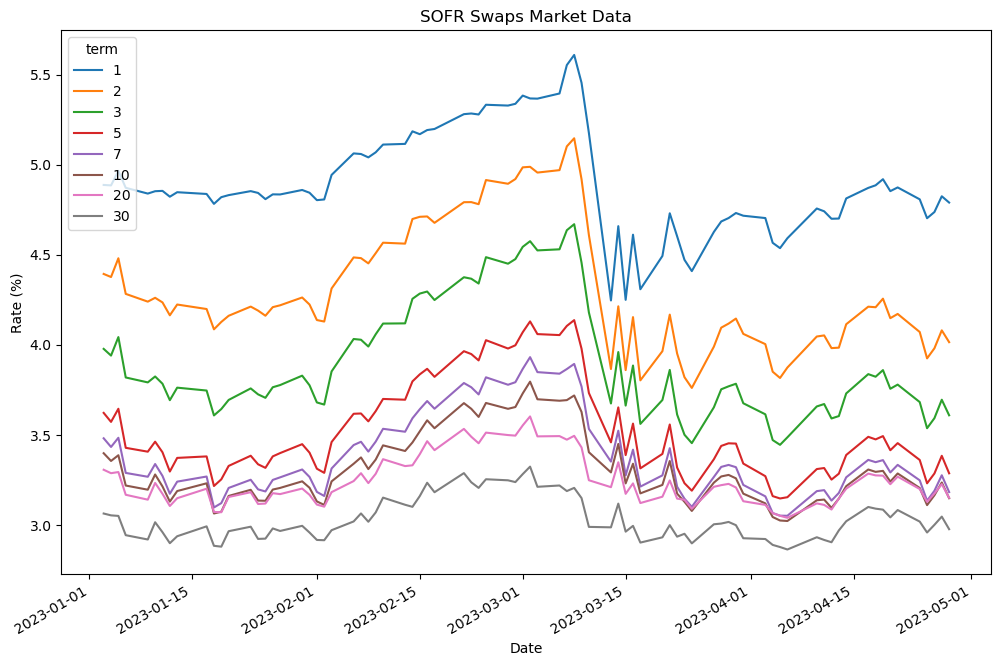

In [467]:
#plot the timeseries for each ticker on the same plot
plot_df = sofr_swaps_market_data_eod1.pivot(index='date', columns='term', values='mid_rate')
plot_df.plot(figsize=(12,8))
plt.title('SOFR Swaps Market Data')
plt.ylabel('Rate (%)')
plt.xlabel('Date')

## b. Calibrate the US SOFR yield curve (via bootstrapping)
The function below shows how to calibrate a smooth yield/discount factor curve from SOFR swaps. 

Prepare a joint symbology & market dataframe quotes as of 2023-04-28. 

Calibrate the SOFR discount factor curve as of 2023-04-28.

Follow section 11b.

#### Setting the calc_date to 2023-04-28

In [468]:
calc_date2 = ql.Date(28, 4, 2023)

#### Preparing the symbology and market dataframes as of 2023-04-28

In [469]:
sofr_swaps_market_data_eod2 = sofr_swaps_market_data_eod1[sofr_swaps_market_data_eod1.date == "2023-04-28"].sort_values(by='term').reset_index(drop=True)
sofr_swaps_market_data_eod2 = sofr_swaps_market_data_eod2.rename(columns={'term':'tenor'})

In [470]:
sofr_swaps_market_data_eod2

,date,symbol,mid_rate,figi,ticker,class,bbg,name,tenor,type,dcc,exchange,country,currency,status
0,2023-04-28,BBG00KFWPJJ9,4.79000,BBG00KFWPJJ9,USOSFR1,Curncy,USOSFR1 Curncy,USD OIS ANN VS SOFR 1Y,1,SWAP,ACT/360,NONE,US,USD,ACTV
1,2023-04-28,BBG00KFWPJX3,4.01500,BBG00KFWPJX3,USOSFR2,Curncy,USOSFR2 Curncy,USD OIS ANN VS SOFR 2Y,2,SWAP,ACT/360,NONE,US,USD,ACTV
2,2023-04-28,BBG00KFWPK15,3.60900,BBG00KFWPK15,USOSFR3,Curncy,USOSFR3 Curncy,USD OIS ANN VS SOFR 3Y,3,SWAP,ACT/360,NONE,US,USD,ACTV
3,2023-04-28,BBG00KFWPK51,3.28700,BBG00KFWPK51,USOSFR5,Curncy,USOSFR5 Curncy,USD OIS ANN VS SOFR 5Y,5,SWAP,ACT/360,NONE,US,USD,ACTV
4,2023-04-28,BBG00KFWPK79,3.18275,BBG00KFWPK79,USOSFR7,Curncy,USOSFR7 Curncy,USD OIS ANN VS SOFR 7Y,7,SWAP,ACT/360,NONE,US,USD,ACTV
5,2023-04-28,BBG00KFWPKB4,3.14875,BBG00KFWPKB4,USOSFR10,Curncy,USOSFR10 Curncy,USD OIS ANN VS SOFR 10Y,10,SWAP,ACT/360,NONE,US,USD,ACTV
6,2023-04-28,BBG00KFWPKF0,3.15105,BBG00KFWPKF0,USOSFR20,Curncy,USOSFR20 Curncy,USD OIS ANN VS SOFR 20Y,20,SWAP,ACT/360,NONE,US,USD,ACTV
7,2023-04-28,BBG00KFWPKH8,2.97675,BBG00KFWPKH8,USOSFR30,Curncy,USOSFR30 Curncy,USD OIS ANN VS SOFR 30Y,30,SWAP,ACT/360,NONE,US,USD,ACTV


In [471]:
def calibrate_sofr_curve_from_frame(
        calc_date: ql.Date,
        sofr_details: pd.DataFrame,
        rate_quote_column: str):
    '''Create a calibrated yield curve from a SOFR details dataframe which includes rate quotes.
    '''
    ql.Settings.instance().evaluationDate = calc_date

    # Sort dataframe by maturity
    sorted_details_frame = sofr_details.sort_values(by='tenor')    
    
    # settle_days
    settle_days = 2
    
    # For US SOFR OIS Swaps 
    day_count = ql.Actual360()

    # For US SOFR Swaps     
    calendar = ql.UnitedStates(ql.UnitedStates.GovernmentBond)
    
    sofr_helpers = []
    
    for index, row in sorted_details_frame.iterrows():
        sofr_quote = row[rate_quote_column]
        tenor_in_years = row['tenor']
        sofr_tenor = ql.Period(tenor_in_years, ql.Years)
        
        # create sofr_rate_helper
        sofr_helper = ql.OISRateHelper(settle_days, sofr_tenor, ql.QuoteHandle(ql.SimpleQuote(sofr_quote/100)), ql.Sofr())
                        
        sofr_helpers.append(sofr_helper)
        
    sofr_yield_curve = ql.PiecewiseLinearZero(settle_days, calendar, sofr_helpers, day_count)
    sofr_yield_curve.enableExtrapolation()
    
    return sofr_yield_curve

In [472]:
sofr_yield_curve = calibrate_sofr_curve_from_frame(calc_date2, sofr_swaps_market_data_eod2, 'mid_rate')

In [473]:
sofr_yield_curve_handle = ql.YieldTermStructureHandle(sofr_yield_curve)

In [474]:
def get_yield_curve_details_df(yield_curve, curve_dates=None):
    
    if(curve_dates == None):
        curve_dates = yield_curve.dates()

    dates = [d.to_date() for d in curve_dates]
    discounts = [round(yield_curve.discount(d), 3) for d in curve_dates]
    yearfracs = [round(yield_curve.timeFromReference(d), 3) for d in curve_dates]
    zeroRates = [round(yield_curve.zeroRate(d, yield_curve.dayCounter(), ql.Compounded).rate() * 100, 3) for d in curve_dates]

    yield_curve_details_df = pd.DataFrame(data={'Date': dates,
                             'YearFrac': yearfracs,
                             'DiscountFactor': discounts,
                             'ZeroRate': zeroRates})                             
    return yield_curve_details_df

In [475]:
# Display SOFR yield curve
grid_dates = [sofr_yield_curve.referenceDate() + ql.Period(i, ql.Years) for i in range(0, 30, 2)]

sofr_yield_curve_simple_df = get_yield_curve_details_df(sofr_yield_curve)                  # using calibration grid
sofr_yield_curve_details_df = get_yield_curve_details_df(sofr_yield_curve, grid_dates)    # using external grid

In [476]:
print(sofr_yield_curve_simple_df)

         Date  YearFrac  DiscountFactor  ZeroRate
0  2023-05-02     0.000           1.000     4.788
1  2024-05-02     1.017           0.954     4.788
2  2025-05-02     2.031           0.923     3.998
3  2026-05-04     3.050           0.898     3.584
4  2028-05-02     5.075           0.850     3.256
5  2030-05-02     7.103           0.802     3.152
6  2033-05-02    10.147           0.732     3.123
7  2043-05-04    20.297           0.534     3.139
8  2053-05-02    30.439           0.419     2.899


## c. Display the calibrated SOFR discount curve dataframe

Follow section 11d to display the calibration details dataframe.

In [477]:
print(sofr_yield_curve_details_df)

          Date  YearFrac  DiscountFactor  ZeroRate
0   2023-05-02     0.000           1.000     4.788
1   2025-05-02     2.031           0.923     3.998
2   2027-05-02     4.058           0.872     3.420
3   2029-05-02     6.089           0.825     3.204
4   2031-05-02     8.117           0.778     3.142
5   2033-05-02    10.147           0.732     3.123
6   2035-05-02    12.175           0.687     3.126
7   2037-05-02    14.206           0.646     3.129
8   2039-05-02    16.233           0.606     3.132
9   2041-05-02    18.264           0.569     3.136
10  2043-05-02    20.292           0.534     3.139
11  2045-05-02    22.322           0.507     3.091
12  2047-05-02    24.350           0.482     3.043
13  2049-05-02    26.381           0.459     2.995
14  2051-05-02    28.408           0.438     2.947


## d. Plot the calibrated US SOFR Zero Interest Rates and Discount Factor curves

Plot the SOFR zero rates and discount factor curves by maturity. Follow section 11c.

Text(0.5, 0, 'Date')

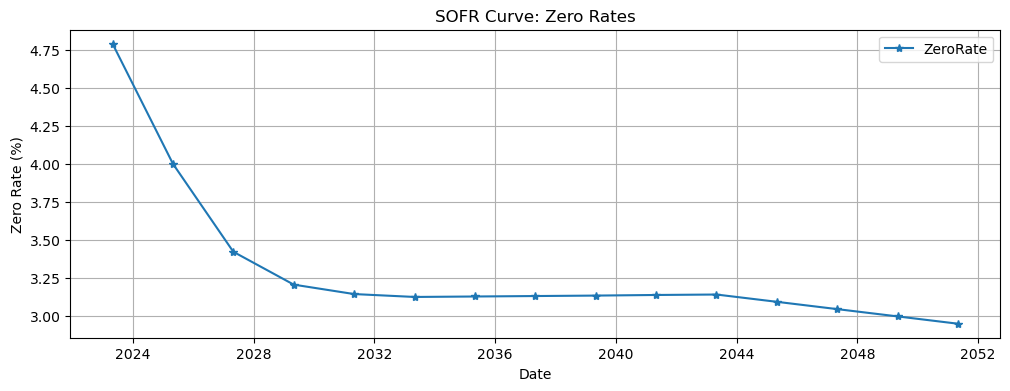

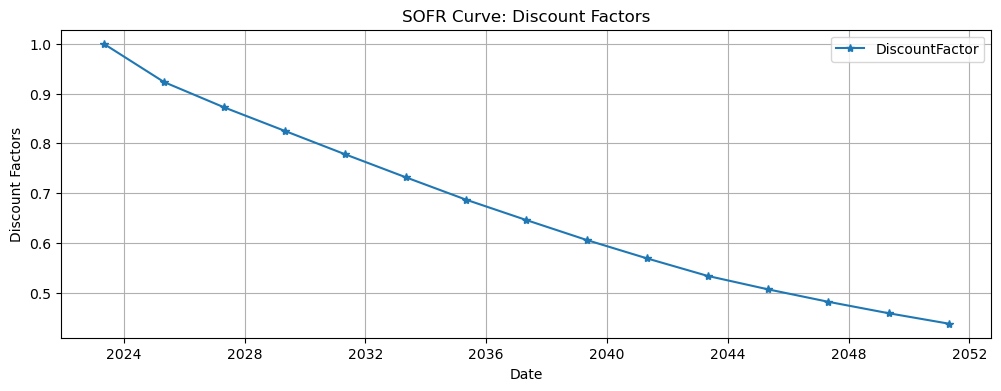

In [478]:
plot = sofr_yield_curve_details_df.plot(x='Date', y='ZeroRate', grid=True, style='*-', title='SOFR Curve: Zero Rates', figsize=(12,4))
plot.set_ylabel('Zero Rate (%)')
plot.set_xlabel('Date')

plot = sofr_yield_curve_details_df.plot(x='Date', y='DiscountFactor', grid=True, style='*-', title='SOFR Curve: Discount Factors', figsize=(12,4))
plot.set_ylabel('Discount Factors')
plot.set_xlabel('Date')

# Problem 4: CDS Hazard Rate calibration and valuation
## Follow Section "12. CDS Hazard Rate calibration + Pricing" in the QuantLib Intro notebook !!!

## a. Load and explore the CDS market data (IBM credit issuer)

Load the `cds_market_data_eod` Excel file into a dataframe. 

Plot the historical time series of CDS Par Spreads for the available tenors.


In [479]:
cds_market_data_eod = pd.read_excel(os.path.join(mydir,'data', 'cds_market_data_eod.xlsx'))

In [480]:
cds_market_data_eod.columns

Index(['date', 'ticker', 'short_name', 'tier', 'sector', 'region', 'currency',
       'doc_clause', 'running_coupon', 'cds_assumed_recovery', 'par_spread_1y',
       'par_spread_2y', 'par_spread_3y', 'par_spread_5y', 'par_spread_7y',
       'par_spread_10y'],
      dtype='object')

#### Confirming if we only have one issuer

In [481]:
cds_market_data_eod.ticker.unique()

array(['IBM'], dtype=object)

#### Keeping only the date and par spread columns

In [482]:
cds_market_data_eod1 = cds_market_data_eod.filter(regex='^par_spread_.*|date')
cds_market_data_eod1

,date,par_spread_1y,par_spread_2y,par_spread_3y,par_spread_5y,par_spread_7y,par_spread_10y
0,2023-01-03,0.001849,0.002584,0.003785,0.005948,0.007627,0.008438
1,2023-01-04,0.001825,0.002549,0.003735,0.005837,0.007540,0.008339
2,2023-01-05,0.001859,0.002566,0.003749,0.005854,0.007558,0.008354
3,2023-01-06,0.001778,0.002453,0.003607,0.005647,0.007362,0.008156
4,2023-01-09,0.001706,0.002368,0.003472,0.005433,0.007133,0.007920
...,...,...,...,...,...,...,...
76,2023-04-24,0.001801,0.002507,0.003701,0.005783,0.007477,0.008231
77,2023-04-25,0.001837,0.002552,0.003787,0.005927,0.007653,0.008438
78,2023-04-26,0.001868,0.002618,0.003829,0.005977,0.007716,0.008502
79,2023-04-27,0.001794,0.002523,0.003683,0.005769,0.007513,0.008300


#### Plotting the historical time series of CDS Par Spreads for the available tenors

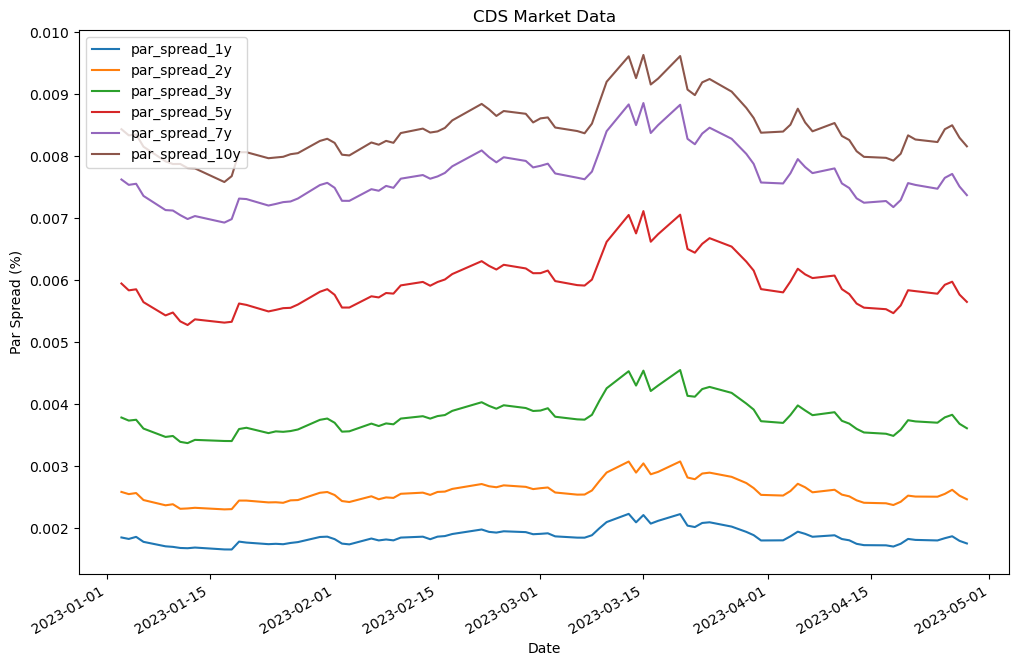

In [483]:
#plot all the columns in cds_market_data_eod1 versus date
cds_market_data_eod1.plot(x='date', figsize=(12,8))
plt.title('CDS Market Data')
plt.ylabel('Par Spread (%)')
plt.xlabel('Date')
plt.show()

## b. Calibrate the IBM hazard rate curve as of 2023-04-28

Follow section 12a. Use the calibrated SOFR discount curve from 2b.

#### Assuming settlement days to 2

In [484]:
# settle_days
settle_days = 2

In [485]:
# cds_market_data_eod1 date == 2023-04-28
cds_market_data_eod2 = cds_market_data_eod1[cds_market_data_eod1.date == "2023-04-28"].reset_index(drop=True)
#convert the row to a list
cds_market_data_eod2 = cds_market_data_eod2.values.tolist()
#remove the date from the list
cds_market_data_eod2 = cds_market_data_eod2[0][1:]
#convert the list to a numpy array
cds_market_data_eod2 = np.array(cds_market_data_eod2)
cds_market_data_eod2

array([0.00175233, 0.00246527, 0.0036115 , 0.00565077, 0.00737379,
       0.00816184])

In [486]:
CDS_recovery_rate = 0.4

# CDS standard tenors: 1Y, 2Y, 3Y, 5Y 7Y and 10Y
CDS_tenors = [ql.Period(y, ql.Years) for y in [1, 2, 3, 5, 7, 10]]
              
# CDS spreads for IBM as of calc_date = 2023-04-28
CDS_spreads = cds_market_data_eod2 * 10000

CDS_helpers = [ql.SpreadCdsHelper((CDS_spread / 10000.0), CDS_tenor, settle_days, ql.TARGET(),
                                  ql.Quarterly, ql.Following, ql.DateGeneration.TwentiethIMM, ql.Actual360(), CDS_recovery_rate, sofr_yield_curve_handle)
               
for (CDS_spread, CDS_tenor) in zip(CDS_spreads, CDS_tenors)]

# bootstrap hazard_rate_curve
hazard_rate_curve = ql.PiecewiseFlatHazardRate(calc_date, CDS_helpers, ql.Actual360())
hazard_rate_curve.enableExtrapolation()

# Display calibrated hazard rates and survival probabilities
hazard_list = [(hr[0].to_date(), hr[1] * 100, hazard_rate_curve.survivalProbability(hr[0])) for hr in hazard_rate_curve.nodes()]
grid_dates, hazard_rates, surv_probs = zip(*hazard_list)

hazard_rates_df = pd.DataFrame(data={'Date': grid_dates, 
                                     'HazardRate': hazard_rates,
                                     'SurvivalProb': surv_probs})
hazard_rates_df


,Date,HazardRate,SurvivalProb
0,2023-04-14,0.289047,1.000000
1,2024-06-20,0.289047,0.996529
2,2025-06-20,0.550078,0.990987
3,2026-06-22,1.032013,0.980616
4,2028-06-20,1.528600,0.950727
5,2030-06-20,2.085259,0.911364
6,2033-06-20,1.749802,0.864084


## c. Plot the calibrated Hazard Rates and Survival Probability curves
Follow section 12b. Use the calibrated SOFR discount curve from 2b.

Text(0.5, 0, 'Date')

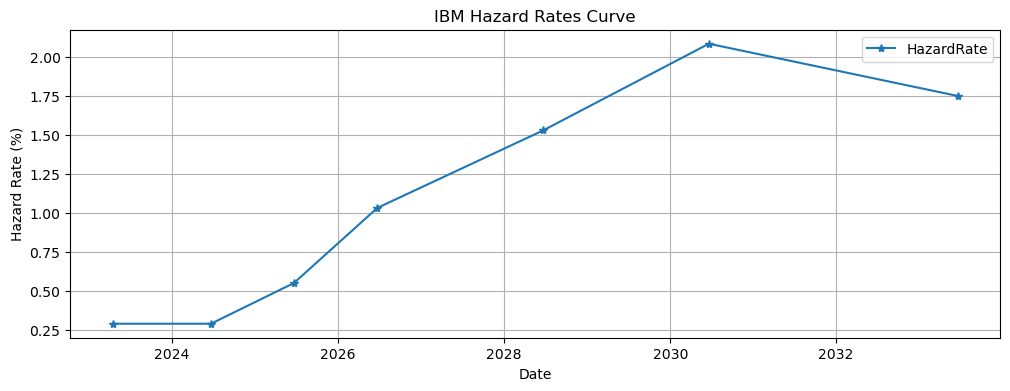

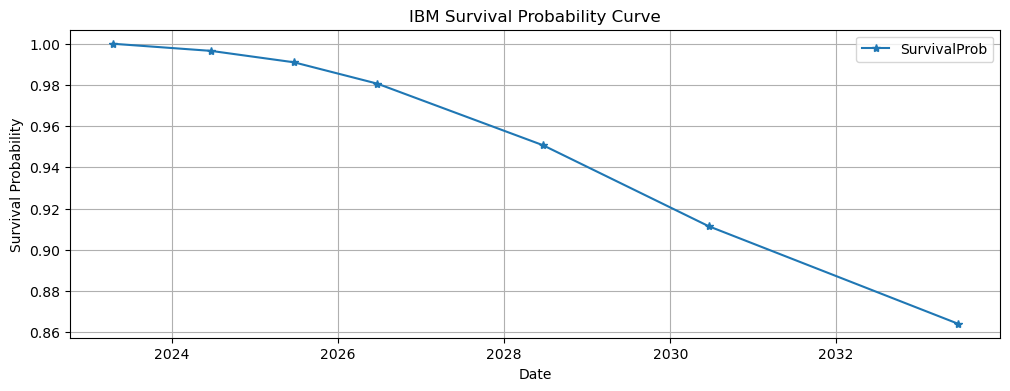

In [487]:
plt = hazard_rates_df.plot(x='Date', y='HazardRate', grid=True, style='*-', title='IBM Hazard Rates Curve', figsize=(12,4))
plt.set_ylabel('Hazard Rate (%)')
plt.set_xlabel('Date')

plt = hazard_rates_df.plot(x='Date', y='SurvivalProb', grid=True, style='*-', title='IBM Survival Probability Curve', figsize=(12,4))
plt.set_ylabel('Survival Probability')
plt.set_xlabel('Date')


## d. Compute the fair/par spread and PV of a CDS 

Follow section 12c. Construct a CDS object with 100 bps coupon and 2027-06-20 maturity. Compute the fair/par spread and PV.




In [488]:
# CDS specs
side = ql.Protection.Seller

face_notional = 100

contractual_spread = 100 / 10000

cds_start_date = ql.Date(28, 4, 2023)
cds_maturity_date = ql.Date(20, 6, 2027)


In [489]:
# Create CDS schedule
cds_schedule = ql.MakeSchedule(cds_start_date, cds_maturity_date, ql.Period('3M'),
                            ql.Quarterly, ql.TARGET(), ql.Following, ql.Unadjusted, ql.DateGeneration.TwentiethIMM)


In [490]:
# Create CDS object
cds_obj = ql.CreditDefaultSwap(side, face_notional, contractual_spread, cds_schedule, ql.Following, ql.Actual360())


In [491]:
# Create CDS pricing engine
default_prob_curve_handle = ql.DefaultProbabilityTermStructureHandle(hazard_rate_curve)
cds_engine = ql.MidPointCdsEngine(default_prob_curve_handle, CDS_recovery_rate, sofr_yield_curve_handle)
cds_obj.setPricingEngine(cds_engine)


In [492]:
print('CDS fair or par spread:', round(cds_obj.fairSpread()*10000, 3))
print('CDS PV:', round(cds_obj.NPV(), 4))

CDS fair or par spread: 48.65
CDS PV: 1.9678


In [493]:
print('CDS protection start date:', cds_obj.protectionStartDate())
print('CDS Premium Leg PV:', round(cds_obj.couponLegNPV(), 4))
print('CDS Default Leg PV', round(cds_obj.defaultLegNPV(), 4))
print('Survival Prob. to Maturity:', round(hazard_rate_curve.survivalProbability(cds_maturity_date), 4))

CDS protection start date: April 28th, 2023
CDS Premium Leg PV: 3.832
CDS Default Leg PV -1.8643
Survival Prob. to Maturity: 0.9656
